# Experiment organization
Goal: Gather results from all topic modeling experiments using many stemming treatments for a particular corpus, then creates some visualizations.
The expected tree structure for the corpus and experiments is as follows:
```
<corpus> # corpus name - 'tiger','rnc' or 'opencorpora'
├── <corpus>_<stemmer> # stemmer or lemmatization treatment name, see topic_modeling/stemming.py for language details
│   ├── <corpus_oracleAnalysis.gz # Only present when stemmer=='oracle', the annotation labels for the words in the corpus, in sequence to match up with state files
│   ├── <corpus>_<stemmer>.mallet # mallet import-dir --output
│   ├── <corpus>_<stemmer>.tsv # output of topic_modeling/corpus_preprocessing.py for this particular treatment
│   ├── <corpus>_<stemmer>_<num_topics>_topics_<num_iters>_iters_<experiment_id> 
│   │   ├── <corpus>_<stemmer>_diagnostics.tsv # mallet train-topics metrics as tsv
│   │   ├── <corpus>_<stemmer>_diagnostics.xml # original mallet train-topics metrics format
│   │   ├── <corpus>_<stemmer>_doc_topics.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_entropy_metrics.tsv # metrics produced by by topic_modeling/mallet_parser slot-entropy
│   │   ├── <corpus>_<stemmer>.model # mallet topic model 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.tsv # mallet train-topics metrics for the version of this model lifted to lemmas 
│   │   ├── <corpus>_<stemmer>_postLemmatized_diagnostics.xml 
│   │   ├── <corpus>_<stemmer>_postLemmatized.mallet # mallet corpus sequence file lifted to lemmas (we probably only need to create this once, but I didn't think of that earlier, so for now each experiment gets its own)
│   │   ├── <corpus>_<stemmer>_postLemmatized.model # mallet topic model lifted to lemmas
│   │   ├── <corpus>_<stemmer>_postLemmatized_state.gz # mallet topic model state file lifted to 
│   │   ├── <corpus>_<stemmer>_state.gz # mallet topic model state file
│   │   ├── <corpus>_<stemmer>_top_docs.txt # mallet train-topics --output-doc-topics 
│   │   ├── <corpus>_<stemmer>_topic_keys.txt # mallet train-topics --output-topic-keys
│   │   ├── <corpus>_<stemmer>_topic_lemmas.tsv # Counts and conditional probablilities of lemmas for each topic
│   │   ├── <corpus>_<stemmer>_topic_pos.tsv  # Counts and conditional probablilities of parts-of-speech for each topic
│   │   ├── <corpus>_<stemmer>_topic_slots.tsv  # Counts and conditional probablilities of detailed morphological analyses for each topic
│   │   └── <corpus>_<stemmer>_top_terms.tsv # Raw counts of top 20 terms for each topic
└── voi_<num_topics>_topics # Variation of information between different models for the same number of topics
    └── <corpus>_<stemmer1>_<experiment1_id>_<corpus>_<stemmer2>_<experiment2_id>.tsv # Compares treatment 1 and treatment 2 

```



In [1]:
from pathlib import Path 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="white")

In [2]:
def parse_experiment_directory(experiment_path):
    """Parses out all topic level metrics from a topic model's TSV results file, given the model's path. 
    Returns topic level metrics as a dataframe
    """
    dir_name = experiment_path.name
    split_name = dir_name.split("_")
    corpus = split_name[0]
    treatment = split_name[1]
    num_topics = split_name[2]
    experiment_id = split_name[-1]
    original_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_diagnostics.tsv", sep="\t", index_col="id", na_filter=False)

    final_frame = original_mallet_diagnostics
    final_frame['negative_coherence'] = - final_frame['coherence']

    final_frame.insert(loc = 0, column="corpus", value = corpus)
    final_frame.insert(loc = 1, column="stemmer", value=treatment)
    final_frame.insert(loc = 2, column="num_topics", value=int(num_topics))
    final_frame.insert(loc = 3, column="experiment_id", value = experiment_id)

    lemma_mallet_diagnostics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_postLemmatized_diagnostics.tsv", sep="\t", index_col="id")
    lemma_mallet_diagnostics.rename(columns = {"exclusivity":"lemma_exclusivity"}, inplace=True)
    
    final_frame["lemma_exclusivity"] = lemma_mallet_diagnostics["lemma_exclusivity"]

    entropy_metrics = pd.read_csv(experiment_path / f"{corpus}_{treatment}_entropy_metrics.tsv", sep = "\t", index_col="topic")

    final_frame = pd.merge(final_frame, entropy_metrics, left_index= True, right_index = True)
    final_frame = final_frame.reset_index().rename(columns={"id":"topic_id"})

    return final_frame

def parse_voi_tsv(voi_tsv):
    """Returns a dataframe for the VOI results in a single VOI tsv output.
    """
    split_name = voi_tsv.name[:-4].split("_")
    stemmer_a = split_name[1]
    a_exp_id = split_name[2]
    stemmer_b = split_name[4]
    b_exp_id = split_name[5]
    voi_frame = pd.read_csv(voi_tsv, sep="\t", index_col=False, names = ["a_path", "b_path", "voi"])
    voi_frame["stemmer_a"] = stemmer_a
    voi_frame["a_experiment_id"] = a_exp_id
    voi_frame["stemmer_b"] = stemmer_b
    voi_frame["b_experiment_id"] = b_exp_id
    if stemmer_a != stemmer_b:
        # VOI is symmetric, so flip them too
        flipped_df = voi_frame.copy()
        flipped_df["stemmer_a"] = stemmer_b
        flipped_df["a_experiment_id"] = b_exp_id
        flipped_df["stemmer_b"] = stemmer_a
        flipped_df["b_experiment_id"] = a_exp_id
        voi_frame = pd.concat([voi_frame, flipped_df], ignore_index=True)
    return voi_frame

def parse_voi_directory(voi_path):
    """Parses out all VOI comparisons between experiments from the TSVs in the VOI directory.
    Returns all VOI comparisons as a dataframe
    """
    tsvs = voi_path.glob("*.tsv")
    return pd.concat([parse_voi_tsv(t) for t in tsvs], ignore_index=True, sort=False)

# Corpus stats

In [3]:
corpus_name = "opencorpora"
corpus_root = Path("/home/virginia/workspace/topic-modeling-study") / corpus_name
experiment_folders = list(corpus_root.glob(f"{corpus_name}_*/*_topics_*_iters_*"))
voi_folders = list(corpus_root.glob("voi_*"))
corpus_stats_tsv = corpus_root / f"{corpus_name}_corpus_stats.tsv"
print("Num experiment folders found:", len(experiment_folders))
print("VOI folders:", voi_folders)

# How to order treatments in plots
hue_order = ["raw", "oracle", "pymystem3", "stanza", "snowball", "truncate6", "truncate5"]

Num experiment folders found: 140
VOI folders: [PosixPath('/home/virginia/workspace/topic-modeling-study/rnc/voi_100_topics'), PosixPath('/home/virginia/workspace/topic-modeling-study/rnc/voi_50_topics')]


,stemmer,token_count,word_type_count,type_to_token_ratio,char_to_token_ratio
0,raw,319911,79466,0.248400,7.52717
1,oracle,319911,32541,0.101719,7.44411
2,pymystem3,319911,30668,0.095864,7.48985
3,snowball,319911,31101,0.097218,5.91594
4,stanza,319911,32802,0.102535,7.33221
5,truncate5,319911,28147,0.087984,4.83540
6,truncate6,319911,39443,0.123294,5.59657


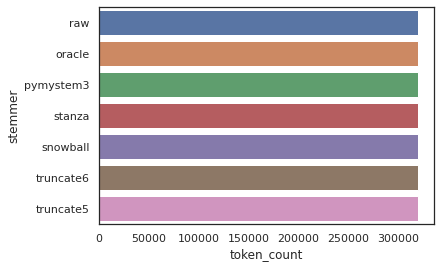

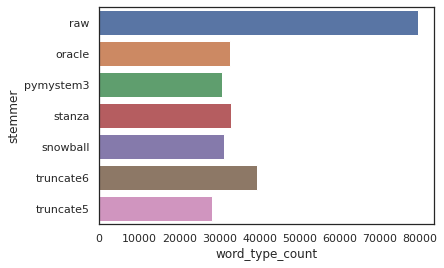

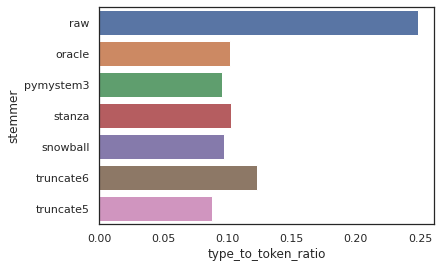

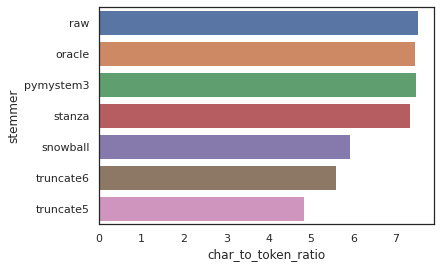

In [4]:
stat_cols = ['token_count', 'word_type_count', 'type_to_token_ratio', 'char_to_token_ratio']
stats_frame = pd.read_csv(corpus_stats_tsv, sep="\t", index_col=False)
display(stats_frame)

for i, c in enumerate(stat_cols):
    plt.figure(i)
    sns.barplot(data = stats_frame, x=c, y="stemmer", order=hue_order)

In [5]:
# Concat all experiment results together, save off results
full_frame = pd.concat([parse_experiment_directory(f) for f in experiment_folders], ignore_index=True, sort=False)
print("Total entries:", len(full_frame))
full_frame.to_csv(corpus_root / f'{corpus_name}_all_experiments_metrics.tsv', sep='\t', index=False)
full_frame.head(3)

Total entries: 10500


,topic_id,corpus,stemmer,num_topics,experiment_id,tokens,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity,negative_coherence,lemma_exclusivity,lemma_entropy,slot_entropy,pos_entropy,lemmas_to_top_20_surface_forms,slots_to_top_20_surface_forms,pos_to_top_20_surface_forms,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,top_term_lemmas_minus_top_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms,num_top_term_lemmas_excluded_by_top_lemmas
0,0,rnc,oracle,50,4,29243.0,5.5175,5.50,-163.7078,4.2063,1.7656,137.9723,0.0239,0.0359,0.0000,0.0026,0.3213,163.7078,0.3213,8.909325,7.186194,2.457320,1.0,10.60,0.45,много время последний год каждый слово другой появиться новый два самый работа начало день конец сила первый теперь человек стать,много время последний год каждый слово другой появиться новый два самый работа начало день конец сила первый теперь человек стать,много время последний год каждый слово другой появиться новый два самый работа начало день конец сила первый теперь человек стать,NaN,NaN,20,0,0
1,1,rnc,oracle,50,4,4834.0,3.0672,8.35,-262.0373,4.4695,2.9532,173.2804,0.0177,0.0240,0.0196,0.0160,0.5022,262.0373,0.5022,8.529651,6.617204,1.696265,1.0,3.75,0.10,компания стандарт разработка предприятие критерий должен обеспечение электронный фирма рынок программа решение жюри работа продукт технология информационный эксперт использование система,компания стандарт разработка предприятие критерий должен обеспечение электронный фирма рынок программа решение жюри работа продукт технология информационный эксперт использование система,компания стандарт разработка предприятие критерий должен обеспечение электронный фирма рынок программа решение жюри работа продукт технология информационный эксперт использование система,NaN,NaN,20,0,0
2,2,rnc,oracle,50,4,3085.0,3.1752,6.30,-193.1083,4.2383,3.4907,212.3006,0.0089,0.2154,0.1176,0.1385,0.3963,193.1083,0.3963,8.863209,6.751277,1.648213,1.0,4.25,0.15,российский лучший место мир олимпиада второй россия метр кубок сезон сборная этап сергей команда чемпионат первый гонка километр женский светлана,российский лучший место мир олимпиада второй россия метр кубок сезон сборная этап сергей команда чемпионат первый гонка километр женский светлана,российский лучший место мир олимпиада второй россия метр кубок сезон сборная этап сергей команда чемпионат первый гонка километр женский светлана,NaN,NaN,20,0,0


In [6]:
num_topics = [50, 100]
num_topics_splits = []
for t in num_topics:
    topic_df = full_frame[full_frame["num_topics"] == t]
    num_topics_splits.append((t, topic_df))

for t, df in num_topics_splits:
    print(t, "topics length:", len(df))



50 topics length: 3500
100 topics length: 7000


# Entropy metrics
Using the annotated corpus as the oracle for lemma, parts of speech and morphological analysis, what's the entropy of topics with respect the original to the grammatical forms of the original wordforms in the documents? 

The treated corpora should have lower lemma entropies, since lemmatiztion forces wordtypes with the same lemma to be together. We would also expect the treated corpora to have higher slot entropy than the raw corpus, because treatments conflate many wordforms with different morphological analyses, but this does not appear to be the case.

- 'raw' has most extreme mean in all cases of entropy metrics - low document entropy & high entropy for grammatical features
- 'raw' (no treatment) has higher lemma and morphological slot entropy than all other treatments. How can the untreated corpus get both higher average lemma entropy and higher average slot entropy? If our expectation is that all forms of a particular lemma concentrate in a given topic (low lemma entropy, high slot entropy), this finding runs counter to that expectation.

<Figure size 432x288 with 0 Axes>

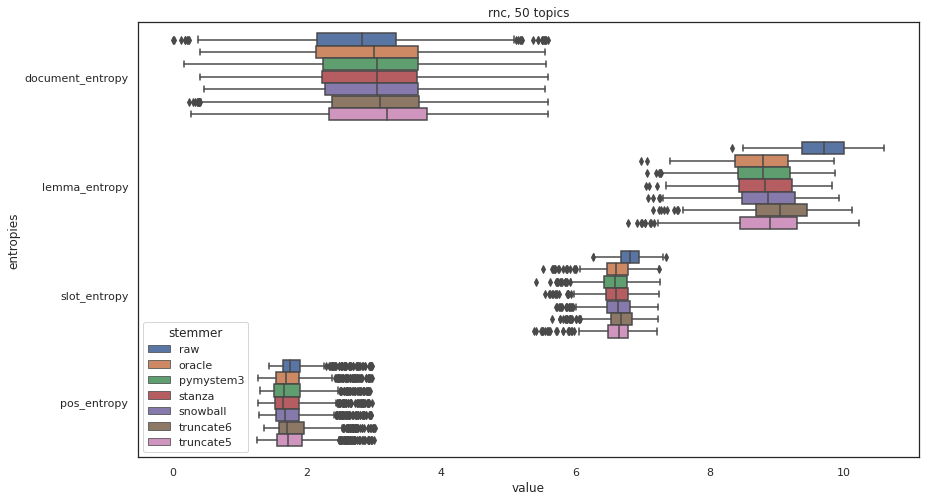

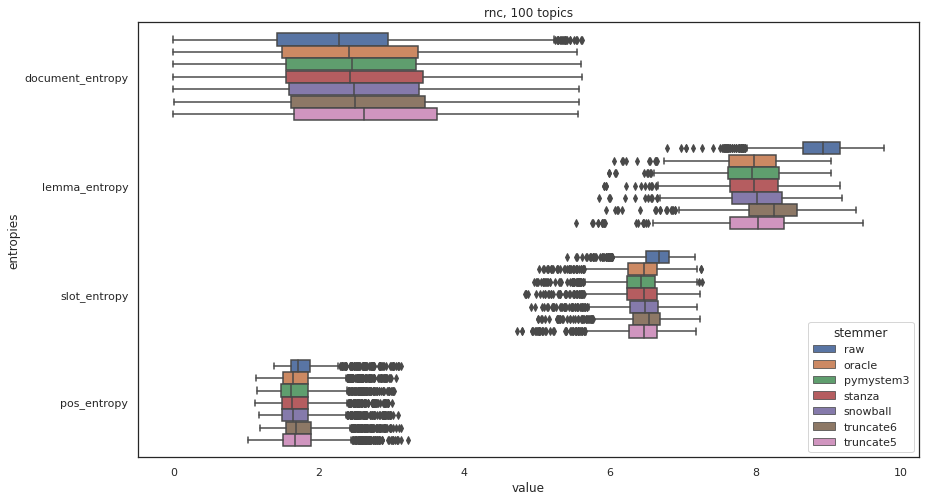

In [7]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    entropy_metrics = ['document_entropy', 'lemma_entropy', 'slot_entropy', 'pos_entropy']
    entropy_stats = pd.melt(df, "stemmer", var_name="entropies", value_vars=entropy_metrics)
    plt.figure(i)
    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="entropies", hue="stemmer", data = entropy_stats, hue_order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

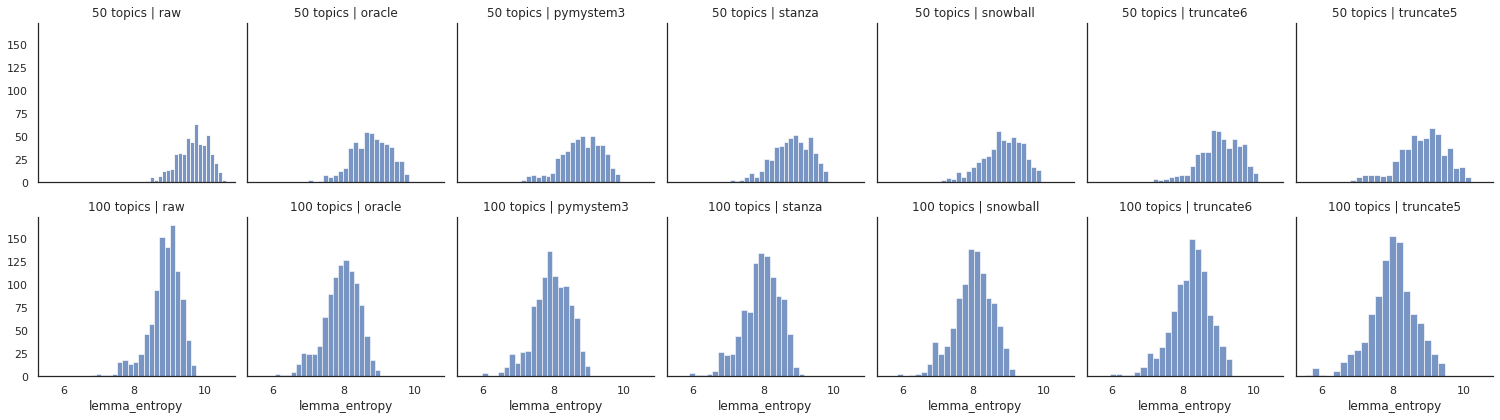

In [8]:
g = sns.FacetGrid(full_frame, col="stemmer", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "lemma_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

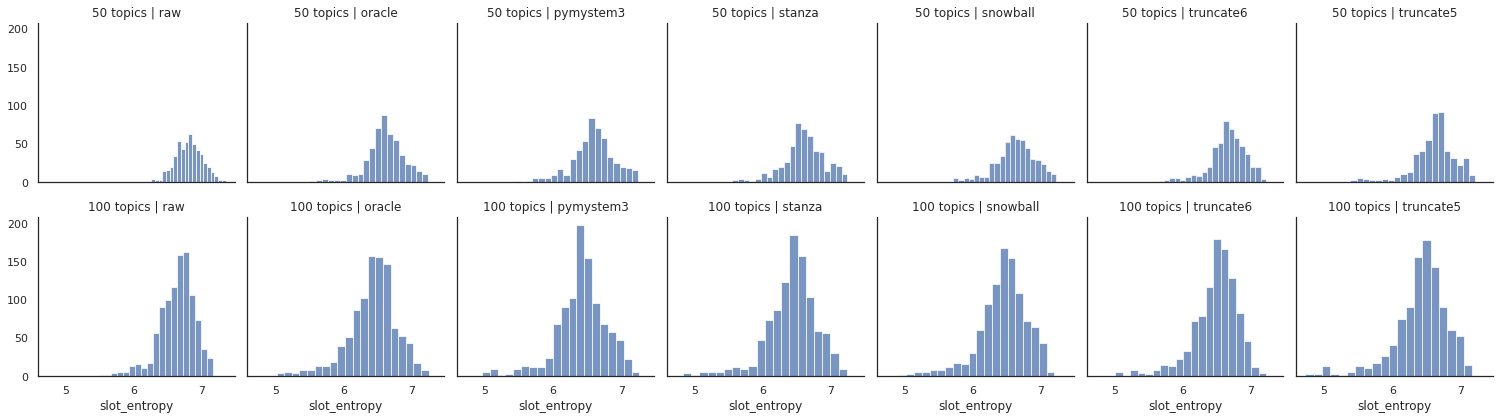

In [9]:
g = sns.FacetGrid(full_frame, col="stemmer", row="num_topics", col_order=hue_order)
g.map(sns.histplot, "slot_entropy", bins=20)
g.set_titles(col_template="{col_name}", row_template= "{row_name} topics")

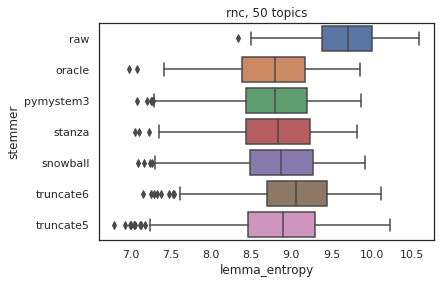

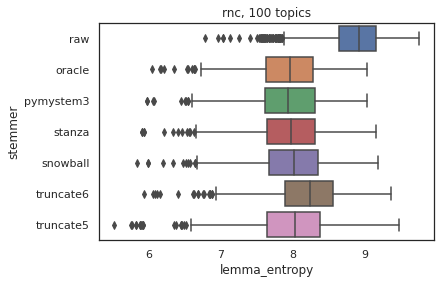

In [10]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemma_entropy', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

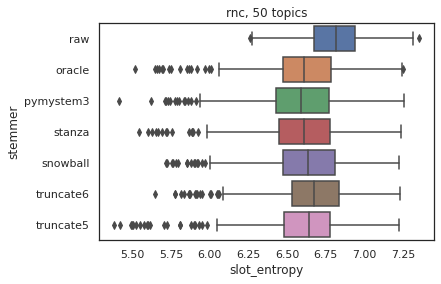

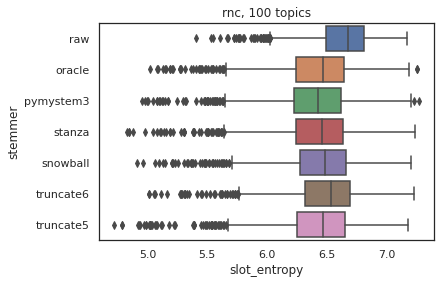

In [11]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slot_entropy', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

<Figure size 432x288 with 0 Axes>

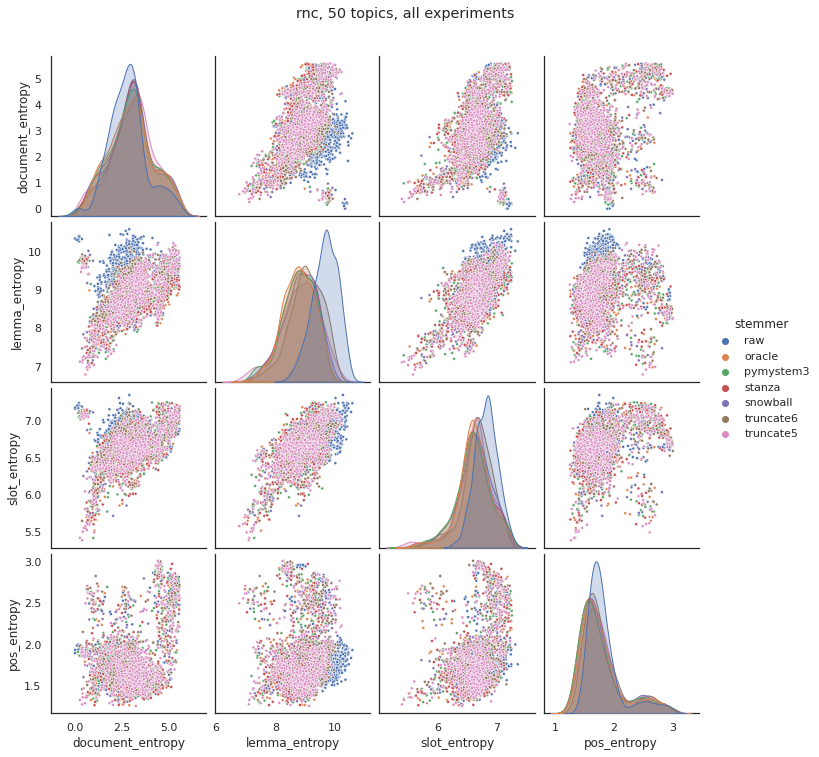

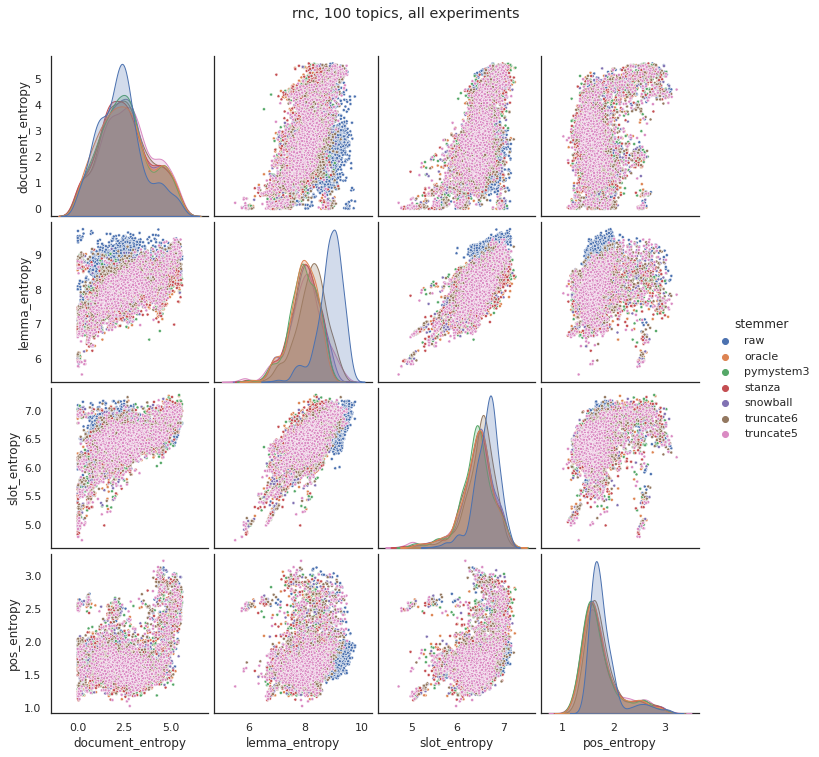

In [12]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    g = sns.pairplot(df, hue="stemmer", vars=entropy_metrics, markers='.', hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name}, {num_topics} topics, all experiments", y = 1.05)

<Figure size 432x288 with 0 Axes>

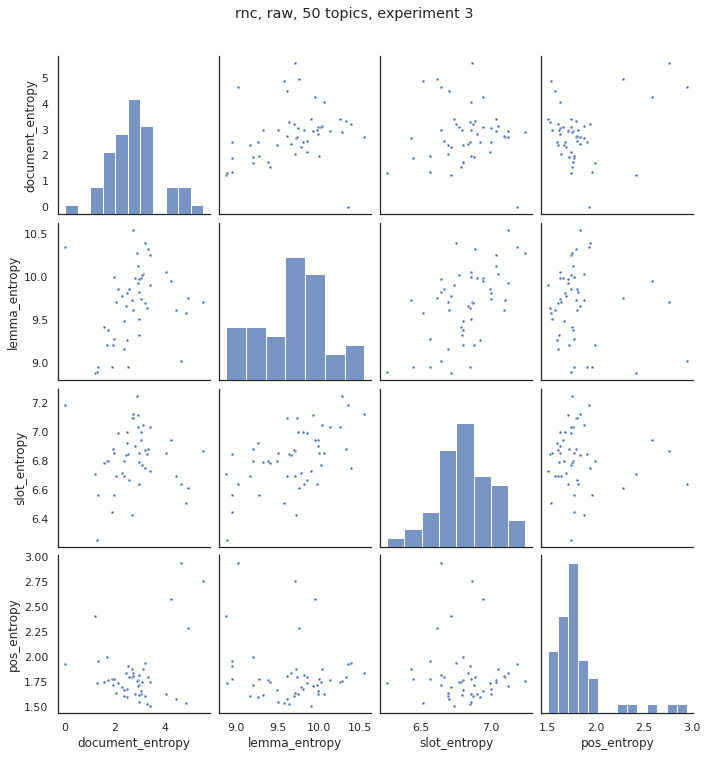

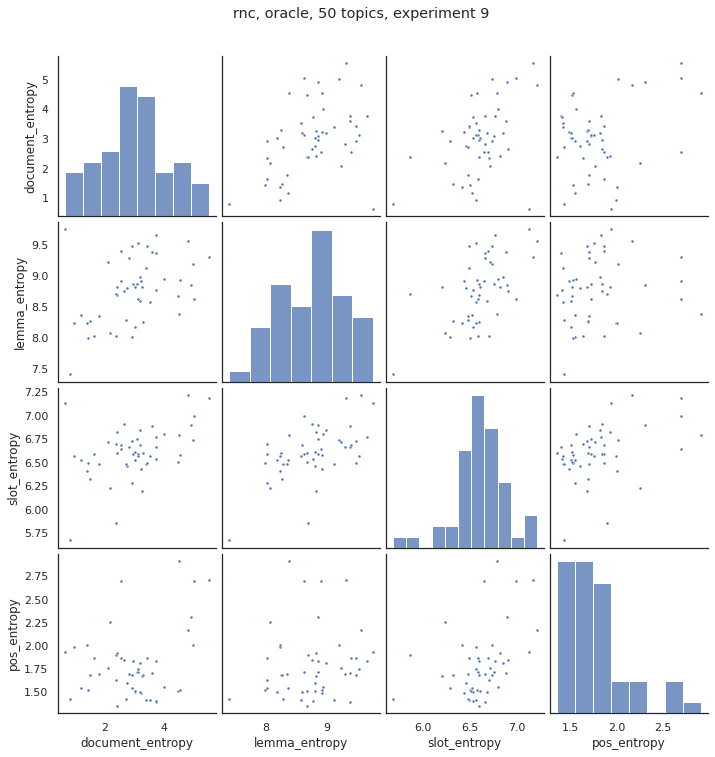

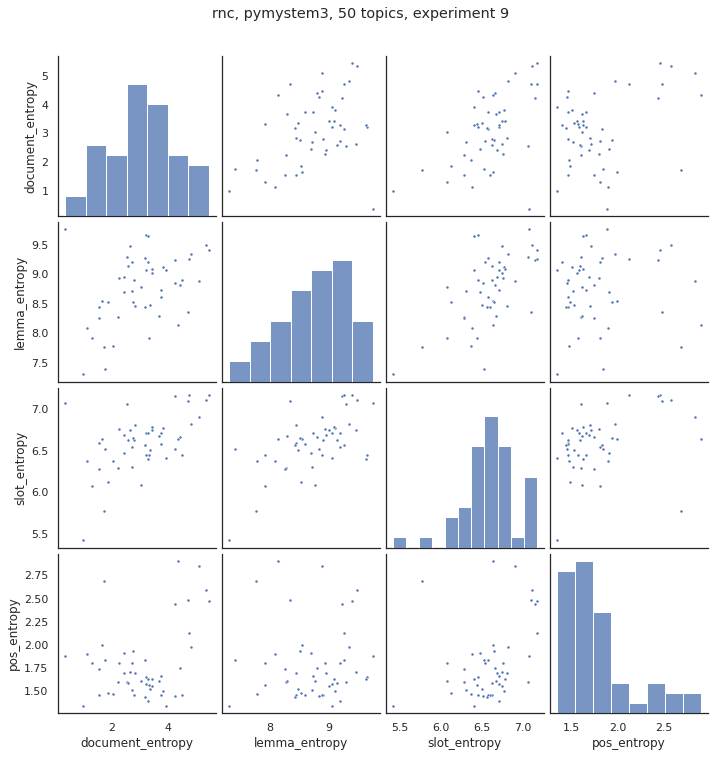

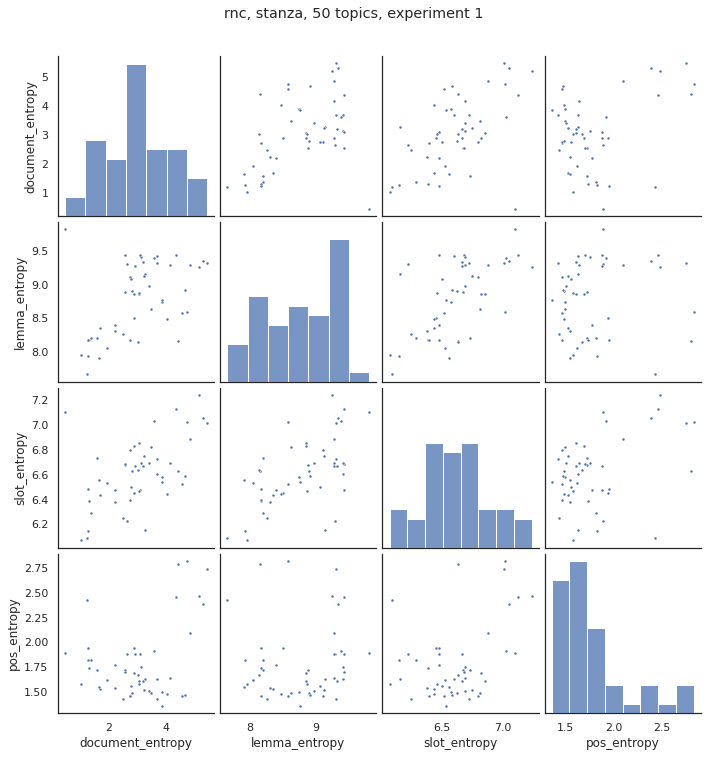

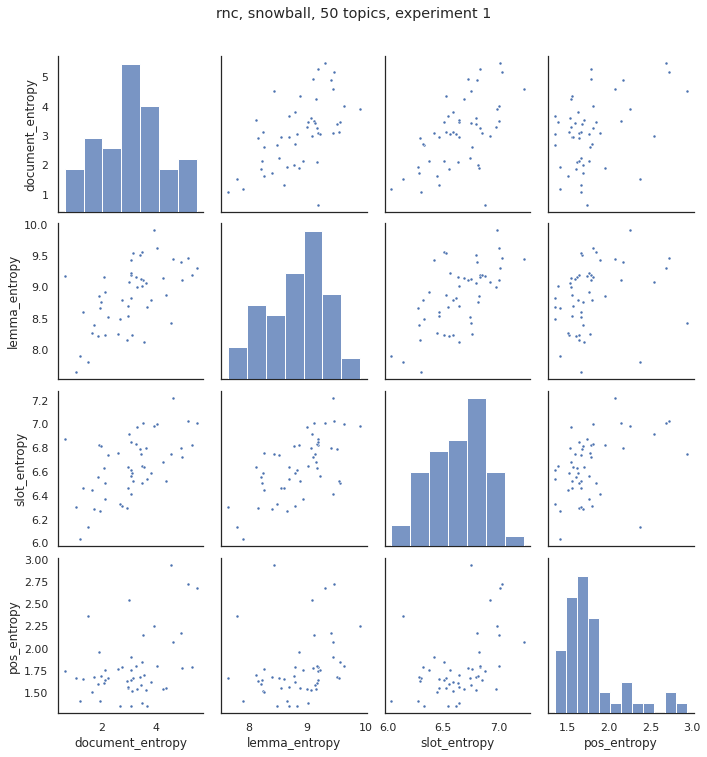

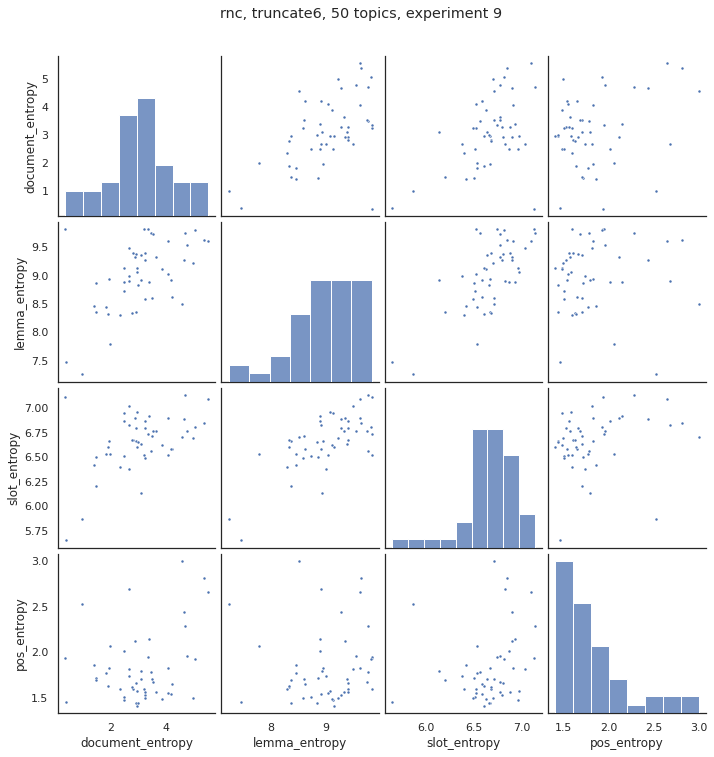

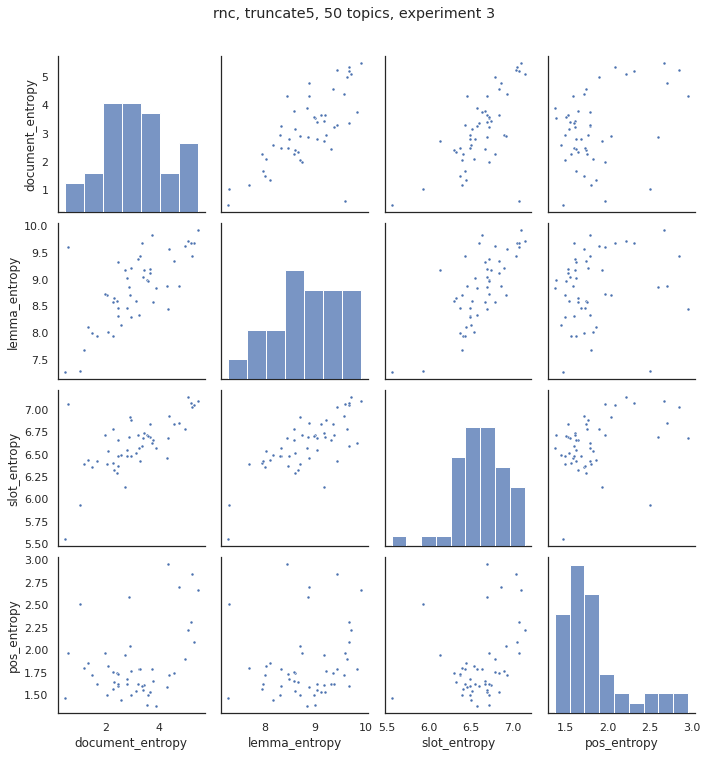

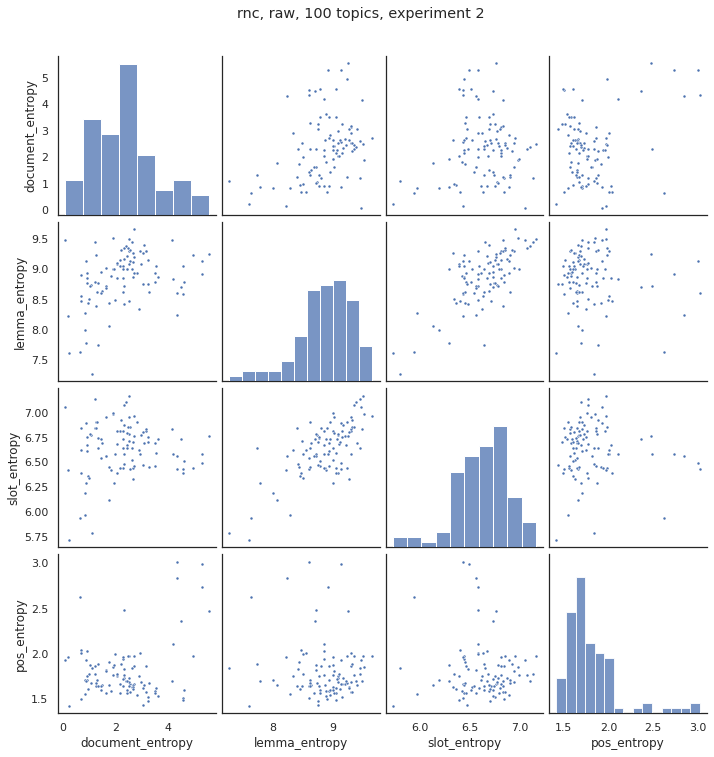

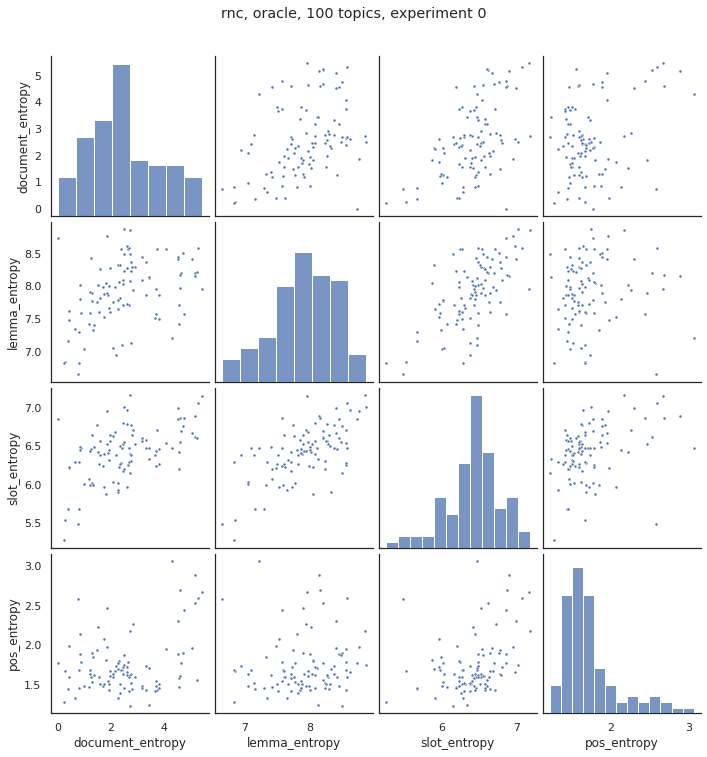

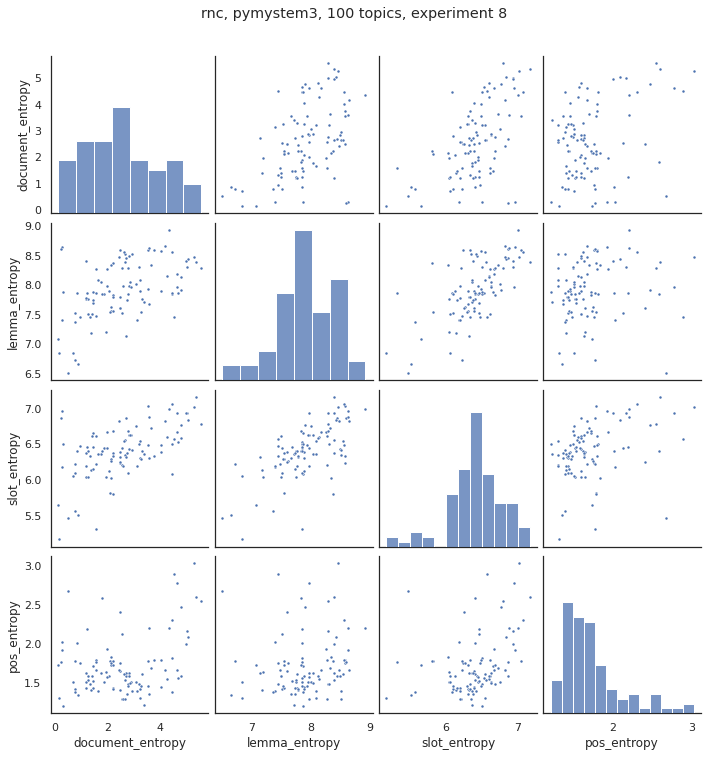

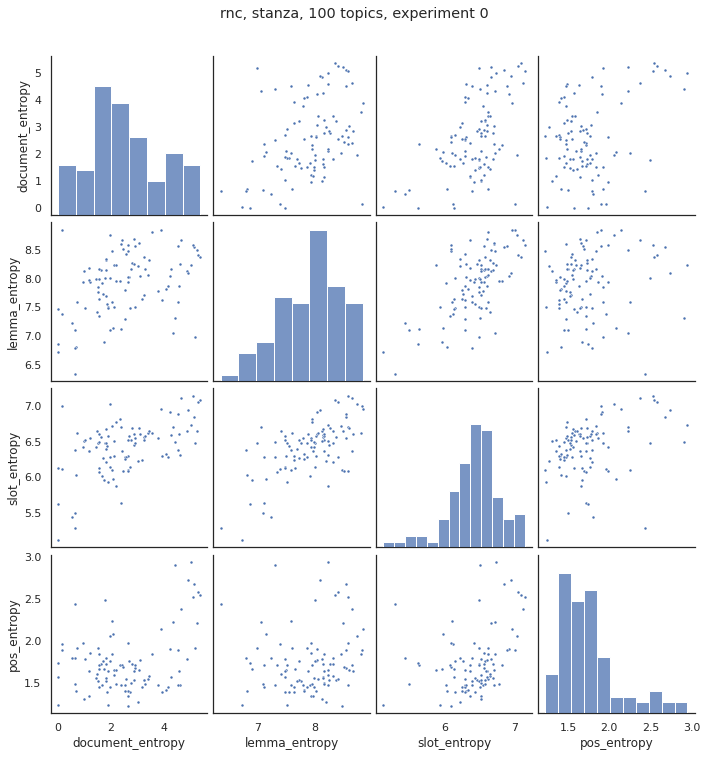

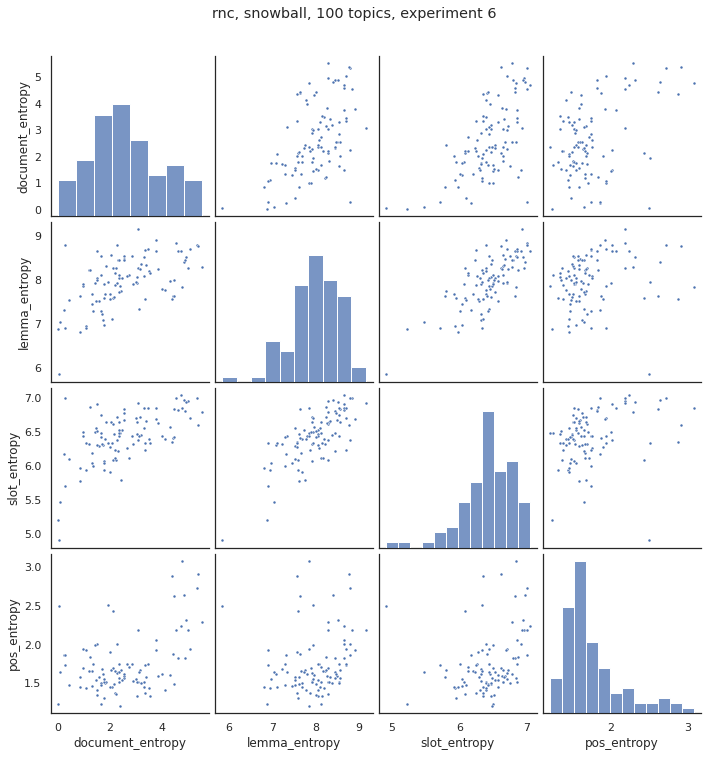

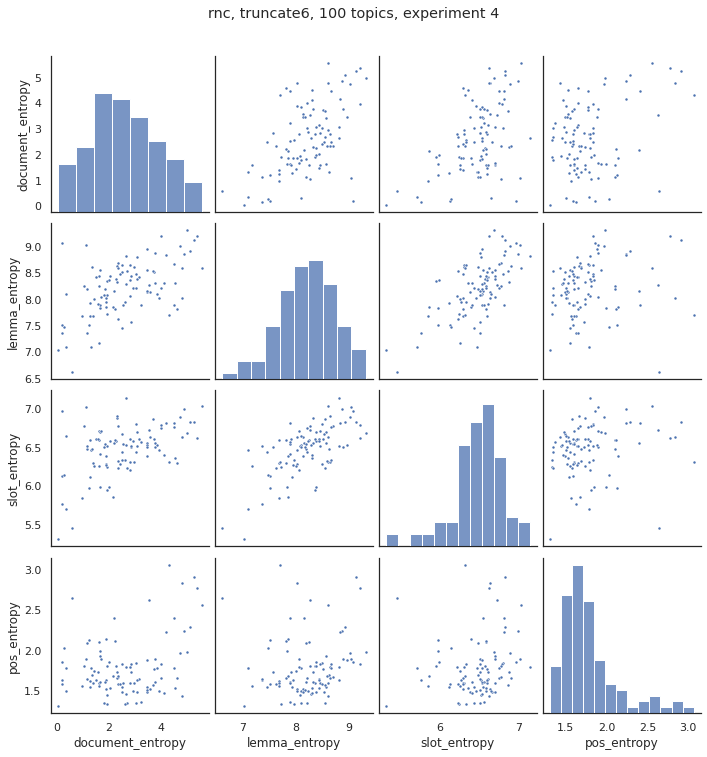

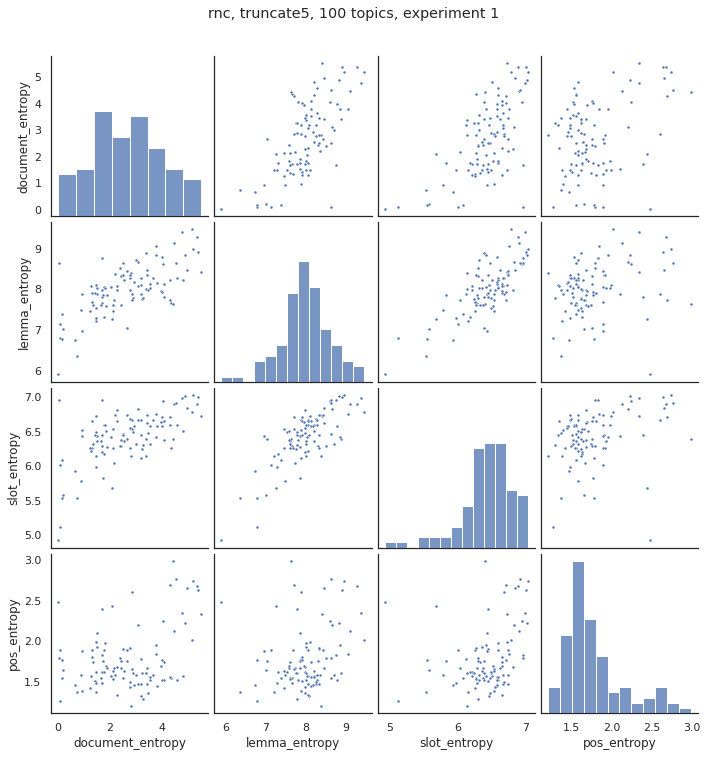

In [14]:
    # The same pair plots for a single experiment in each stemmer type
    counter = 0
    for i, pair in enumerate(num_topics_splits):
        num_topics, df = pair
        for treatment in hue_order:
            tmp_df = df[df['stemmer'] == treatment]
            experiment_id = random.randrange(10)
            tmp_df = tmp_df[tmp_df['experiment_id'] == str(experiment_id)]
            plt.figure(counter)
            g = sns.pairplot(tmp_df, vars=entropy_metrics, markers='.')
            g.fig.suptitle(f"{corpus_name}, {treatment}, {num_topics} topics, experiment {experiment_id}", y = 1.05)
            counter+=1

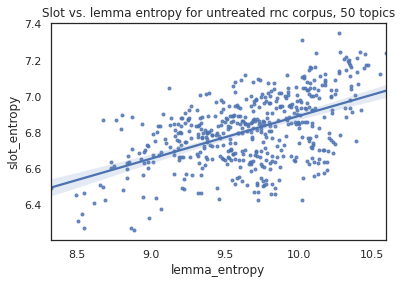

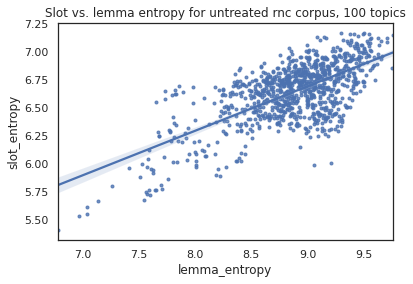

In [15]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    raw_df = df[df['stemmer'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=raw_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name} corpus, {num_topics} topics")

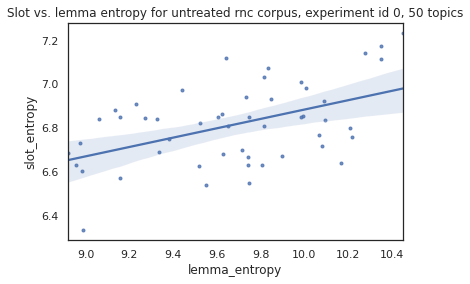

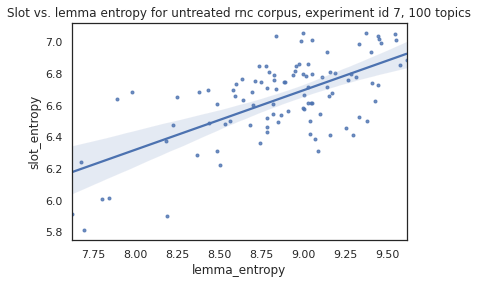

In [16]:
# Compare slot vs lemma entropy for a single experiment
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    experiment_id = random.randrange(10)
    tmp_df = df[df['experiment_id'] == str(experiment_id)]
    tmp_df = tmp_df[tmp_df['stemmer'] == 'raw'][['experiment_id', 'topic_id', 'num_topics', 'lemma_entropy', 'slot_entropy', 'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms', 'top_lemmas_minus_top_term_lemmas', 'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms']]
    sns.regplot(data=tmp_df, x="lemma_entropy", y="slot_entropy", marker=".").set_title(f"Slot vs. lemma entropy for untreated {corpus_name} corpus, experiment id {experiment_id}, {num_topics} topics")

In [17]:
raw_df.sort_values(['lemma_entropy', 'slot_entropy'], inplace=True)
print("Topics with no treatment, sorted by ascending lemma entropy and slot entropy")
print("Head - low lemma entropy")
display(raw_df.head(5))
print("Tail - high lemma entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending lemma entropy and slot entropy
Head - low lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
2363,1,13,100,6.782294,5.402878,смех языке знаете любви угу кп насколько замечательной ам аа знал кадры россию ээ аплодисменты наверно значит русском т мм,смех американец угу кп насколько ам а знать э любовь кадр русский наверно значит россия т язык мм значить замечательный,смех угу кп насколько ам а знать э любовь кадр русский аплодисменты наверно значит россия т язык мм значить замечательный,американец,20,1
2867,9,67,100,6.968371,5.531798,т угу ээ аа русском любви кадры россию ам замечательной мм наверно смех значит дед знаете аплодисменты второго насколько кп,т угу ам знать мм замечательный э наверно смех отец россия значит язык дед значить русский приехать а насколько кп,т угу ээ любовь второй э-э так ам знать мм замечательный э наверно смех россия значит дед значить русский аплодисменты кадр а насколько кп,отец язык приехать,24,3
1690,6,40,100,7.037227,5.551870,языке наверно мм знал русском смех ээ дед приехали т кадры знаете угу замечательной ам россию кп значит аа насколько,а знать наверно мм бунин смех американец э дед т язык замечательный угу ам россия кп значит русский английский насколько,а знать наверно мм смех ээ э дед т приехать язык замечательный угу значить кадр так ам россия кп значит русский насколько,американец бунин английский,22,3
2176,5,26,100,7.041830,5.610905,русском любви дед знал мм языке знаете кадры замечательной кп ээ наверно россию угу значит т тогда ам смех аа,язык россия мм английский знать русский приехать замечательный бунин американец а кп наверно э угу значит т тогда ам смех,язык россия дед мм значить знать русский любовь замечательный а кп ээ наверно э кадр угу значит т тогда ам смех,приехать английский американец бунин,21,4
2788,4,88,100,7.132587,5.665548,мм кадры смех русском языке аа россию наверно аплодисменты ээ знаете ам значит любовь угу знал кп насколько т замечательной,отец россия замечательный мм смех а знать наверно ам значит любовь угу американец кп э насколько русский кадр т язык,россия замечательный мм кадры смех а знать наверно аплодисменты ээ ам значит любовь угу кп э насколько русский кадр значить т язык,отец американец,22,2


Tail - high lemma entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
1968,2,18,100,9.661577,6.958889,земле площадь окно семейного смерти земли игры пору времён пусть святого вокруг горло найдётся музыка видеть души тела ночь ибо,чужой время земля церковь площадь окно стена игра пусть смерть вокруг автор святой тело пора душа видеть век ночь ибо,время земля площадь окно игра пусть смерть вокруг горло семейный найтись святой тело пора душа музыка видеть ночь ибо,чужой автор церковь стена век,19,5
1588,0,38,100,9.701077,7.122398,рекой поэтом рукой воде мужики руки ильич петрович мартынов пошёл арнольд углу чтоб доме рукавички купить избу вороны давно сердце,дом ильич вода пить рука стол петрович изба решить вологодский арнольд пойти чтоб поэт купить угол сунуться река мужик давно,ворона дом ильич вода рука петрович изба мартынов арнольд рукавичка пойти чтоб поэт купить угол река мужик давно сердце,пить стол сунуться решить вологодский,19,5
1720,6,70,100,9.707146,7.088942,виктор витя коли реку руку поэту бог вологде полу вологодских чаще доме писателей рубцов хорошо куда дербина поэтом семеновна долго,пол романов витя вологда коля часто вологодский поэт писатель бог дебаркадер поплавок река марья ворона рубцов хорошо дербина рука семеновна,пол виктор витя коли вологда коля часто вологодский поэт дом писатель бог река рубцов хорошо куда дербина рука семеновна долго,марья романов ворона дебаркадер поплавок,20,5
2779,4,79,100,9.748230,6.852360,занятия имя науки жизнь образ самый центре музыка мысли современной тело книгу книга писал солнца души внимания книги смерти вокруг,отец искусство имя жизнь образ мысль самый современный множество тело называть писать книга солнце внимание душа предмет вокруг наука смерть,внимание самый душа тело писать имя центр книга вокруг жизнь современный музыка наука солнце занятие образ мысль смерть,множество отец искусство называть предмет,18,5
2791,4,91,100,9.756828,7.148881,петрович берегу левом берег реки каким нинка поэзии люблю коли река семеновна пошёл колей дебаркадера насчёт видать поплавок человека лодки,петрович дебаркадер лодка рука берег какой диван нинка катер поэт всякий человек марья рубцов пойти река семеновна коля любить поплавок,петрович поэзия дебаркадер лодка человек|человек левый берег какой нинка человек коли пойти река семеновна коля насчет любить видать поплавок,марья диван рубцов рука катер поэт всякий,19,7


In [18]:
raw_df.sort_values(['slot_entropy', 'lemma_entropy'], ascending=[True, False], inplace=True)
print("Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy")
print("Head - low slot entropy")
display(raw_df.head(5))
print("Tail - high slot entropy")
raw_df.tail(5)

Topics with no treatment, sorted by ascending slot entropy, then descending lemma entropy
Head - low slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
2363,1,13,100,6.782294,5.402878,смех языке знаете любви угу кп насколько замечательной ам аа знал кадры россию ээ аплодисменты наверно значит русском т мм,смех американец угу кп насколько ам а знать э любовь кадр русский наверно значит россия т язык мм значить замечательный,смех угу кп насколько ам а знать э любовь кадр русский аплодисменты наверно значит россия т язык мм значить замечательный,американец,20,1
2867,9,67,100,6.968371,5.531798,т угу ээ аа русском любви кадры россию ам замечательной мм наверно смех значит дед знаете аплодисменты второго насколько кп,т угу ам знать мм замечательный э наверно смех отец россия значит язык дед значить русский приехать а насколько кп,т угу ээ любовь второй э-э так ам знать мм замечательный э наверно смех россия значит дед значить русский аплодисменты кадр а насколько кп,отец язык приехать,24,3
1690,6,40,100,7.037227,5.551870,языке наверно мм знал русском смех ээ дед приехали т кадры знаете угу замечательной ам россию кп значит аа насколько,а знать наверно мм бунин смех американец э дед т язык замечательный угу ам россия кп значит русский английский насколько,а знать наверно мм смех ээ э дед т приехать язык замечательный угу значить кадр так ам россия кп значит русский насколько,американец бунин английский,22,3
2176,5,26,100,7.041830,5.610905,русском любви дед знал мм языке знаете кадры замечательной кп ээ наверно россию угу значит т тогда ам смех аа,язык россия мм английский знать русский приехать замечательный бунин американец а кп наверно э угу значит т тогда ам смех,язык россия дед мм значить знать русский любовь замечательный а кп ээ наверно э кадр угу значит т тогда ам смех,приехать английский американец бунин,21,4
2788,4,88,100,7.132587,5.665548,мм кадры смех русском языке аа россию наверно аплодисменты ээ знаете ам значит любовь угу знал кп насколько т замечательной,отец россия замечательный мм смех а знать наверно ам значит любовь угу американец кп э насколько русский кадр т язык,россия замечательный мм кадры смех а знать наверно аплодисменты ээ ам значит любовь угу кп э насколько русский кадр значить т язык,отец американец,22,2


Tail - high slot entropy


,experiment_id,topic_id,num_topics,lemma_entropy,slot_entropy,top_20_term_set,top_20_lemma_set,lemmas_in_top_20_terms,top_lemmas_minus_top_term_lemmas,num_lemmas_in_top_20_terms,num_top_lemmas_excluded_by_top_terms
2511,3,61,100,9.409946,7.158553,рома ладно шубы николай зато волгу км красоты готовит села уголь камий плов требовала французы кайоль тепло площадь валенки пирог,рома ладно николай волга теплый зато готовить уголь кемерово километр красота француз камий плов нормальный тепло фомин площадь валенок село,рома ладно николай волга теплый зато готовить требовать валенок уголь сесть километр красота француз камий плов кайоль шуба тепло площадь пирог село,фомин нормальный кемерово,22,3
2638,8,88,100,9.487787,7.159081,лесов стихи стихотворение мусор душе рода заболоцкий стихов николай окно набережной музыка романов возле поэзии лёгкие знал принялся леса земли,поэзия стихи снег стихотворение приняться мусор волк заболоцкий николай окно стих мурзилка музыка ветер возле земля знать душа род лес,поэзия стихи стихотворение приняться легкое мусор заболоцкий легкий набережная николай роман окно стих музыка романов возле земля знать душа род лес,волк снег ветер мурзилка,21,4
2880,9,80,100,9.546204,7.159993,едва рома любишь лежал звезда майкл сказала волгу бабы словно самой нежности женой реже комнату вроде голосом беду мари-франс говоря,рома самый звезда майкл редко алена сказать лежать словно волга голос сам баба нежность беда идти вроде мари-франс говорить жена,едва рома самый редко звезда майкл сказать лежать словно голос волга сам баба нежность беда любить комната вроде мари-франс говорить жена,идти алена,21,2
1634,0,84,100,9.293120,7.164622,добрый жён гость михаил вопрос валентин билеты борнео американцев михайловичем алло чтоб задорнов радио воронеж концерт эфире недавно михайлович здравствуйте,отвечать добрый гость любимый михаил вопрос эфир валентин рассказать борнео молодой алло жена задорнов рассказывать радио концерт недавно михайлович серьезный,добрый гость американец михаил вопрос эфир валентин борнео|борнео борнео алло билет жена чтоб задорнов радио|радио радио воронеж концерт недавно михайлович здравствуйте,отвечать молодой рассказать рассказывать серьезный любимый,21,6
1999,2,49,100,9.500953,7.167521,мужа будто звонит самой люблю предложил голосом руку грудь друга мари-франс подросток зачем рома открываю открывает дверь вдоль любовью муж,будто рука звонить волга друг грудь стас подросток узнать нежность зачем рома открывать предложить вдоль муж голос майкл любить баба,будто рука звонить друг грудь мари-франс подросток зачем рома открывать предложить дверь вдоль любовь сам муж голос любить самый,волга узнать нежность майкл стас баба,19,6


# Metrics dealing with the top terms and top lemmas for a topic
This covers exclusivity, ratios of morphological features to terms, lemmas covered or excluded by top terms. 

Treatment reduces exclusivity of the word type used by the topic model. 
Word types being more exclusive than lemmas means there's at least one word type that is concentrated in a particular topic. 


The number of lemmas in the top 20 terms (and the ratio of lemmas to top 20 forms) shows how much conflation each treatment causes - in the topic's key terms. Truncation and Stanza cause the most. Surprisingly, snowball doesn't have as large an effect. 

<Figure size 432x288 with 0 Axes>

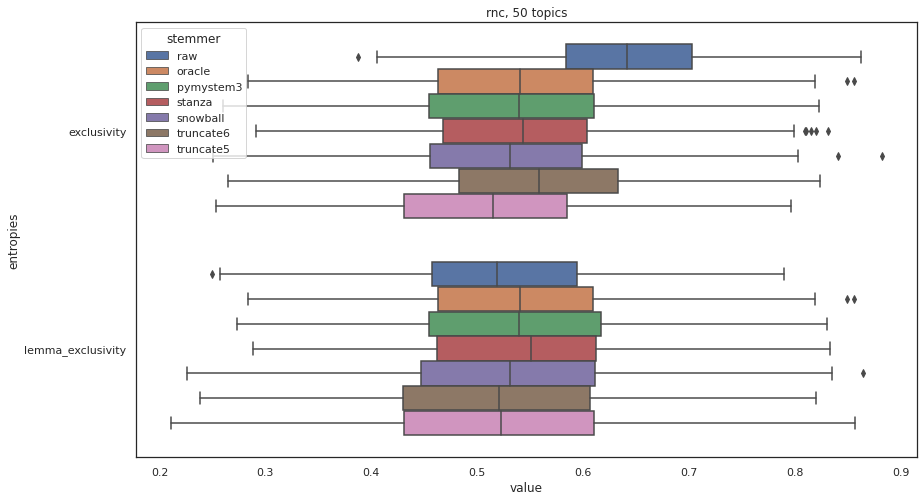

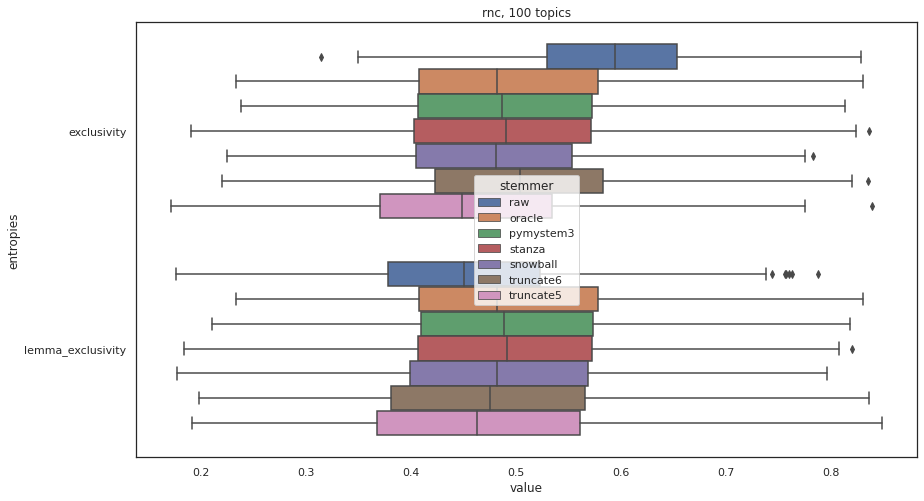

In [19]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    exclusivity_metrics = ['exclusivity', 'lemma_exclusivity']#, 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms']
    exclusivity_stats = pd.melt(df, "stemmer", var_name="entropies", value_vars=exclusivity_metrics)

    fig, axs = plt.subplots(figsize=(14, 8))
    sns.boxplot(x="value", y="entropies", hue="stemmer", data=exclusivity_stats, hue_order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

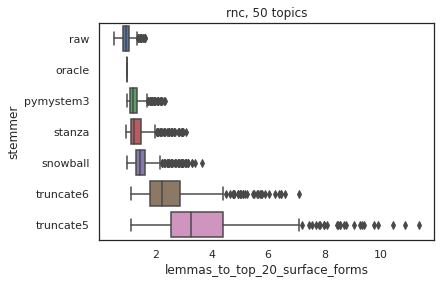

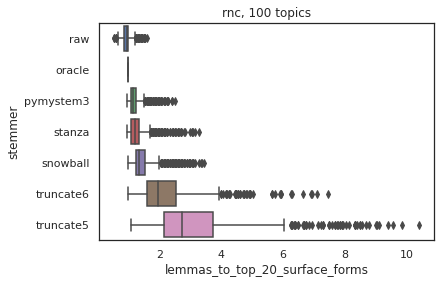

In [20]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='lemmas_to_top_20_surface_forms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

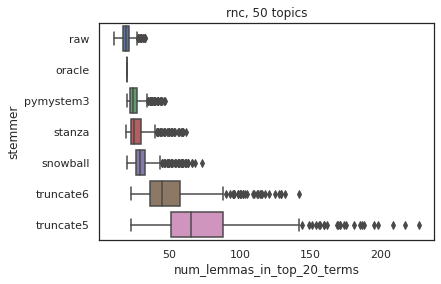

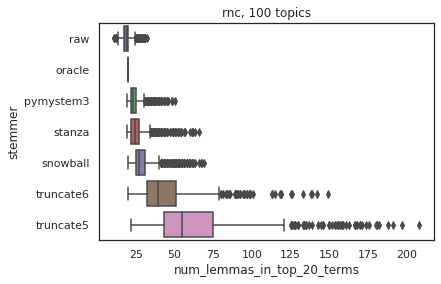

In [21]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_lemmas_in_top_20_terms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

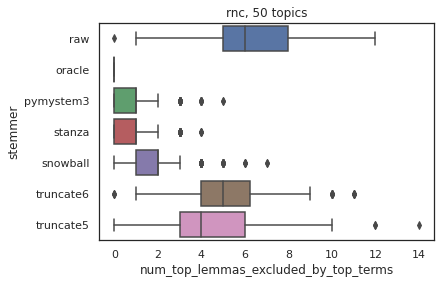

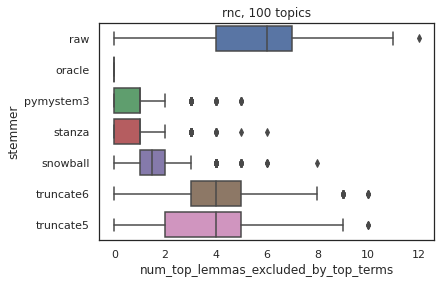

In [22]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='num_top_lemmas_excluded_by_top_terms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

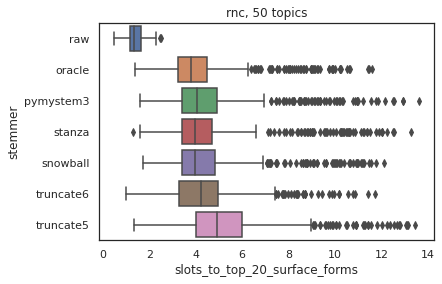

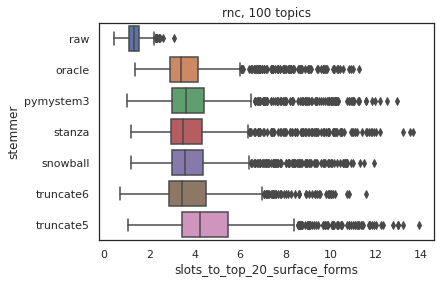

In [23]:
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    plt.figure(i)
    sns.boxplot(x='slots_to_top_20_surface_forms', y='stemmer', data=df, order=hue_order).set_title(f"{corpus_name}, {num_topics} topics")

In [24]:
# Sanity check - oracle exlusivity and oracle post-lemmatize exclusivity should be the same
for i, pair in enumerate(num_topics_splits):
    num_topics, df = pair
    oracle_df = df[df["stemmer"] == "oracle"]
    print("Num_topics:", num_topics)
    print("\tOracle exclusivity:", oracle_df['exclusivity'].mean())
    print("\tOracle lemma (post-lemmatize) exclusivity:", oracle_df['lemma_exclusivity'].mean())

Num_topics: 50
	Oracle exclusivity: 0.5378109999999999
	Oracle lemma (post-lemmatize) exclusivity: 0.5378109999999999
Num_topics: 100
	Oracle exclusivity: 0.4950643
	Oracle lemma (post-lemmatize) exclusivity: 0.4950643


# Variation of Information

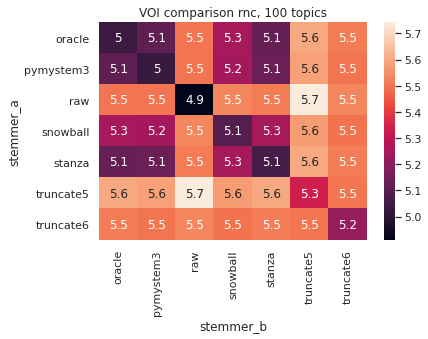

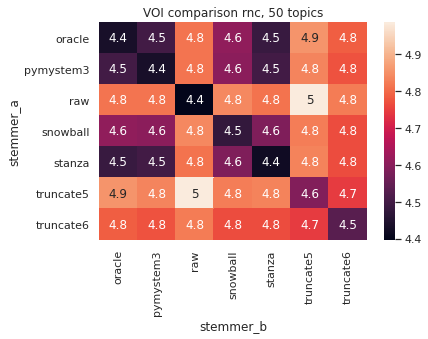

In [25]:
for i, voi in enumerate(voi_folders):
    num_topics = voi.name.split("_")[1]
    voi_frame = parse_voi_directory(voi)
    voi_means = voi_frame.groupby(["stemmer_a", "stemmer_b"], as_index=False)["voi"].mean()
    voi_means = voi_means.pivot(index="stemmer_a", columns="stemmer_b", values="voi")
    plt.figure(i)
    sns.heatmap(voi_means, annot=True).set_title(f"VOI comparison {corpus_name}, {num_topics} topics")


# General diagnostics
These are the standard diagnostics produced by Mallet

In [26]:
full_frame.columns

Index(['topic_id', 'corpus', 'stemmer', 'num_topics', 'experiment_id',
       'tokens', 'document_entropy', 'word-length', 'coherence',
       'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff',
       'rank_1_docs', 'allocation_ratio', 'allocation_count', 'exclusivity',
       'negative_coherence', 'lemma_exclusivity', 'lemma_entropy',
       'slot_entropy', 'pos_entropy', 'lemmas_to_top_20_surface_forms',
       'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms',
       'top_20_term_set', 'top_20_lemma_set', 'lemmas_in_top_20_terms',
       'top_lemmas_minus_top_term_lemmas', 'top_term_lemmas_minus_top_lemmas',
       'num_lemmas_in_top_20_terms', 'num_top_lemmas_excluded_by_top_terms',
       'num_top_term_lemmas_excluded_by_top_lemmas'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

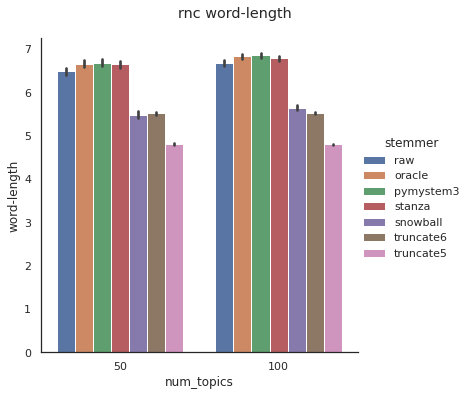

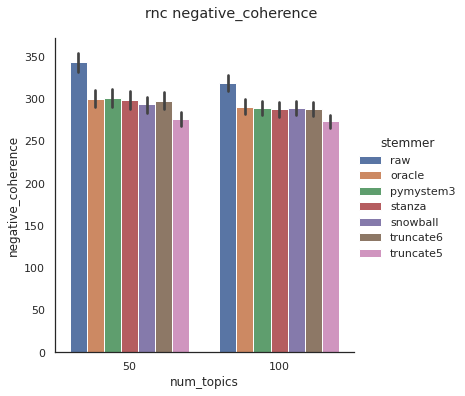

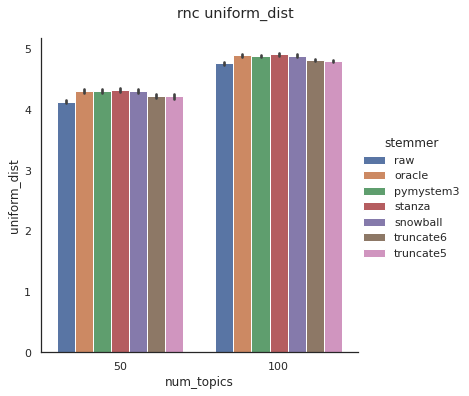

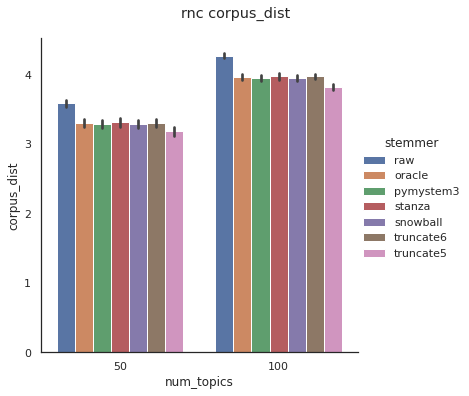

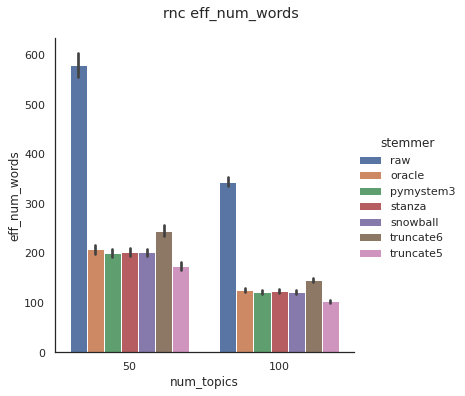

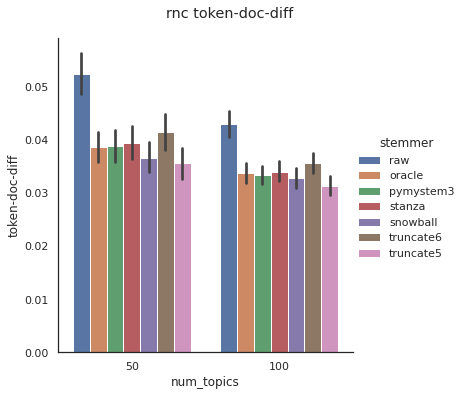

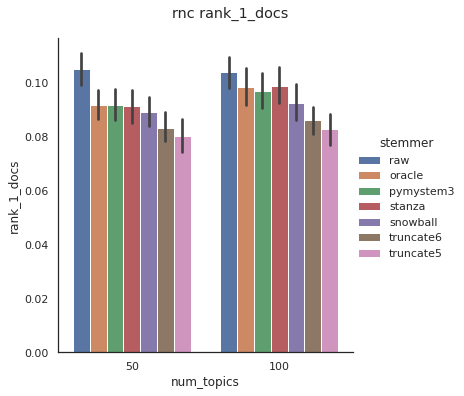

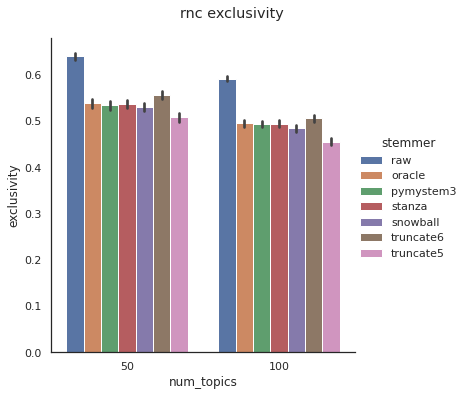

In [27]:
mallet_diagnostics = ['word-length', "negative_coherence", 'uniform_dist', 'corpus_dist', 'eff_num_words', 'token-doc-diff', 'rank_1_docs', 'exclusivity']
for i, m in enumerate(mallet_diagnostics):
    plt.figure(i)
    g = sns.catplot(data = full_frame, kind="bar", x="num_topics", y=m, hue="stemmer", hue_order=hue_order)
    g.fig.suptitle(f"{corpus_name} {m}", y=1.05)
